### Test WENO with Autograd


In [1]:
# import numpy as np
import jax.numpy as np

import matplotlib.pyplot as plt
from rk_integrate import rk_integrate
from deathrate import a
%load_ext line_profiler


%load_ext autoreload
%autoreload 2


def better_imshow(row_vals, col_vals, data, ax=None):
    #row_vals and col_vals are the data that was swept over
    assert len(row_vals) == data.shape[0], 'length of row_vals does not match shape of data'
    assert len(col_vals) == data.shape[1], 'length of col_vals does not match shape of data'
    if ax == None:
        plt.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
    else:
        ax.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')

#### Find Reference

In [2]:



L_list = np.linspace(0,0.5, 50)
tlist = np.linspace(0,1e-5,10000) 
# L_list = np.linspace(0,0.5, 50)  # uniform dL assumed below
# tlist = np.linspace(0,1e-5,1000) 

S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution

L_matrix = np.tile(L_list, (len(L_list),1))
for i in range(len(L_list)):
     # L_matrix[i,:i] = 0
     L_matrix = L_matrix.at[i,:i].set(0)
     
a_L_list = a(L_list)
a_L_matrix = a(L_matrix)

B0 = np.zeros_like(L_list)  # nucleation birth matrix
# B0[0] = 1
B0 = B0.at[0].set(1)

#parameters, plus some precomuted arraays
p = {"L_list" : L_list, #discretization bins
     "L_matrix" : L_matrix,
     "a_L_list" : a_L_list,
     "a_L_matrix" : a_L_matrix,
     "dL" : L_list[1]-L_list[0],
     "B0" : B0,
     'E' :  1e-7, #evaporation rate
     'V' : 1e-3, #solvent volume
     'rho' : 1200, # density of the crystal
     'k_v' : 1, #goes in N_C, volumetric shape factor
     'k_g' : 1e6, #growth rate constant m/s
     'g' : 3, #power constant for growth
     'k_N' : 1e5, #nucleation rate constant 
     'alpha' :5, #power constant for nucleation
     'Breakage': True, #toggle breakage for debug
     'weno': True  # use weno or not for differentiation w.r.t. L
     }



#integrate the equations
x0 = np.hstack([S0, V0, n0])
from evalf import evalf
from dndt import calc_dndt
from birthrate import crystal_birth_breakage, crystal_birth_nucleation
from deathrate import a
# %lprun -f evalf -f calc_dndt -f crystal_birth_breakage -f crystal_birth_nucleation x_t = rk_integrate(x0, t_vec = tlist, p = p) 

x_t_ref = rk_integrate(x0, t_vec = tlist, p = p) 




TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function rk_loop at /Users/hannahgold/Desktop/MIT2023-2024/6.7300 Modelling and Simulation/crystalPBM/with_autodiff/rk_integrate.py:9 for jit. This concrete value was not available in Python because it depends on the value of the argument p['weno'].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [34]:
import numpy as onp

# Save reference file 
onp.save('x_t_ref.npy', x_t_ref)
onp.load('x_t_ref.npy')


array([[1.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 6.3328008e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.5713571e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [9.3639247e-02, 1.0000000e+00, 1.5343753e+00, ..., 3.1419288e-05,
        1.4272773e-05, 7.6947763e-06],
       [9.3584798e-02, 1.0000000e+00, 1.5344017e+00, ..., 3.1429365e-05,
        1.4277547e-05, 7.6974238e-06],
       [9.3530439e-02, 1.0000000e+00, 1.5344279e+00, ..., 3.1439427e-05,
        1.4282314e-05, 7.7000677e-06]], dtype=float32)

#### Plot Reference 

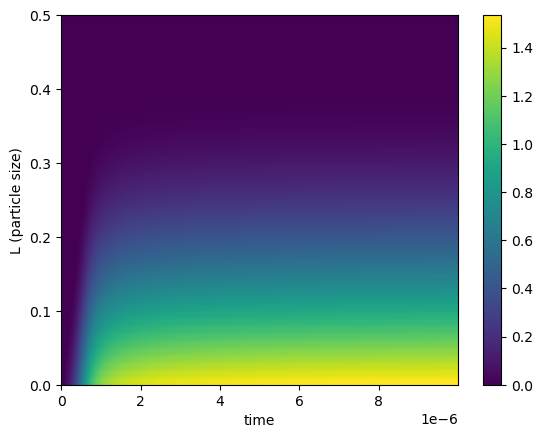

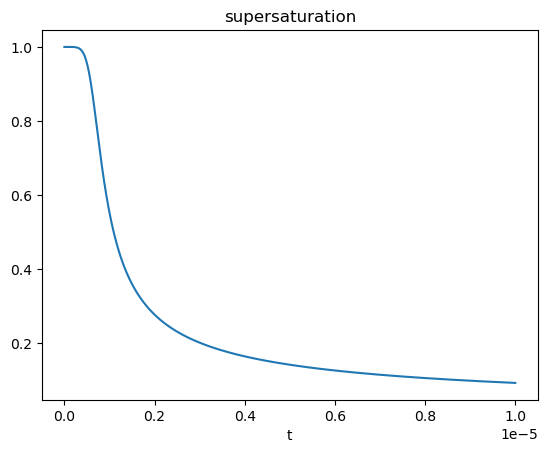

Text(0.5, 0, 't')

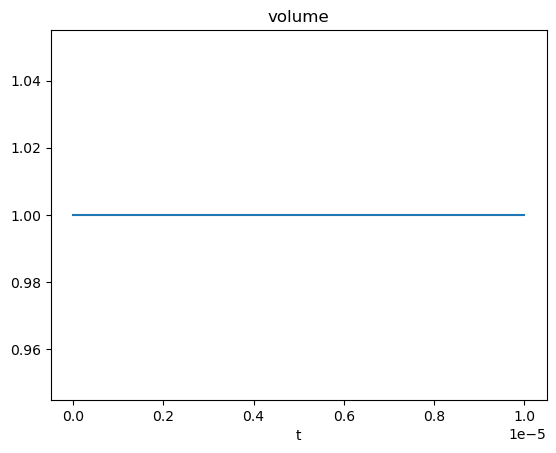

In [35]:
x_t =x_t_ref

#plot results
n_t = x_t[:,2:]
better_imshow(L_list, tlist, n_t.T)
plt.ylabel('L (particle size)')
plt.xlabel('time')
plt.colorbar()
plt.show()

plt.plot(tlist, x_t[:,0]) 
plt.title('supersaturation')
plt.xlabel('t')
plt.show()

plt.plot(tlist, x_t[:,1]) 
plt.title('volume')
plt.xlabel('t')

#### With Weno 


In [ ]:



L_list = np.linspace(0,1e-2, 1000)
tlist = np.linspace(0,1e-2,1000) 


S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution

#parameters
p = {"L_list" : L_list, #discretization bins
     'E' :  1e-7, #evaporation rate
     'rho' : 1200, # density of the crystal
     'k_v' : 1, #goes in N_C, volumetric shape factor
     'k_g' : 1e-3, #growth rate constant m/s
     'g' : 1, #power constant for growth
     'k_N' : 1e5, #nucleation rate constant 
     'alpha' :2, #power constant for nucleation
     'Breakage': True, #toggle breakage for debug
     'weno': True  # use weno or not for differentiation w.r.t. L
     }


#integrate the equations
x = np.hstack([S0, V0, n0])
x_t = odeint(evalf, y0=x, t=tlist, args=(p,None))


#plot results
n_t = x_t[:,2:]
better_imshow(L_list, tlist, n_t.T)
plt.ylabel('L (particle size)')
plt.xlabel('time')
plt.colorbar()
plt.show()

plt.plot(tlist, x_t[:,0]) 
plt.title('supersaturation')
plt.xlabel('t')
plt.show()

plt.plot(tlist, x_t[:,1]) 
plt.title('volume')
plt.xlabel('t')

### Without Weno

In [ ]:



L_list = np.linspace(0,1e-2, 1000)
tlist = np.linspace(0,3,1000) 


S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution

#parameters
p = {"L_list" : L_list, #discretization bins
     'E' :  1e-7, #evaporation rate
     'rho' : 1200, # density of the crystal
     'k_v' : 1, #goes in N_C, volumetric shape factor
     'k_g' : 1e-3, #growth rate constant m/s
     'g' : 1, #power constant for growth
     'k_N' : 1e5, #nucleation rate constant 
     'alpha' :2, #power constant for nucleation
     'Breakage': True, #toggle breakage for debug
     'weno': False  # use weno or not for differentiation w.r.t. L
     }


#integrate the equations
x = np.hstack([S0, V0, n0])
x_t = odeint(evalf, y0=x, t=tlist, args=(p,None))


#plot results
n_t = x_t[:,2:]
better_imshow(L_list, tlist, n_t.T)
plt.ylabel('L (particle size)')
plt.xlabel('time')
plt.colorbar()
plt.show()

plt.plot(tlist, x_t[:,0]) 
plt.title('supersaturation')
plt.xlabel('t')
plt.show()

plt.plot(tlist, x_t[:,1]) 
plt.title('volume')
plt.xlabel('t')